# 0.0. IMPORTS

In [1]:
import pandas as pd
import numpy as np

from IPython.display import Image
from IPython.display import HTML

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

In [3]:
from inflection import underscore

## 0.1. Helper Functions

In [107]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [24, 12]
    plt.rcParams['font.size'] = 40
       
    sns.set()
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Data

!cd  && forfiles

In [5]:
df_sales_raw = pd.read_csv('../../data/train.csv', low_memory=False)
df_store_raw = pd.read_csv('../../data/store.csv')

# merging --> key column = Store
df_raw = df_sales_raw.merge(df_store_raw, on='Store')

# 1.0. DATA DESCRIPTION

In [6]:
df01 = df_raw.copy()

## 1.1. Rename Columns

In [7]:
# lower and separating by _
df01.columns = df_raw.columns.to_series().apply(lambda x: underscore(x))

## 1.2. Data Dimensions

In [8]:
print(f'Number of Rows: {df01.shape[0]}')
print(f'Number of Columns: {df01.shape[1]}')

Number of Rows: 1017209
Number of Columns: 18


## 1.3. Data Types

In [9]:
df01.sample(3)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
685360,753,2,2014-02-18,9470,810,1,1,0,0,d,c,540.0,11.0,2012.0,1,35.0,2010.0,"Mar,Jun,Sept,Dec"
518634,569,5,2014-09-12,4075,625,1,0,0,0,a,a,1340.0,9.0,2006.0,0,NaN,NaN,NaN
677282,744,3,2013-07-17,7812,863,1,1,0,0,a,a,1370.0,12.0,2011.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


In [10]:
df01.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [11]:
df01['date'] = pd.to_datetime(df01['date'])

## 1.4. Check NA

In [12]:
df01.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

## 1.5. Fillout NA's

In [13]:
#competition_distance --> fill with a really big distante --> implies --> no competition
df01['competition_distance'].fillna(max(df01['competition_distance']) * 3,
                                    inplace=True)

#### The next 4 "since" attributes --> Filling the respective label ( month, year) of the sale date
#### Because if since month = sale month --> the difference will be 0
#competition_open_since_month --> fill with the month of the sale
df01['competition_open_since_month'].fillna(
    df01.loc[df01['competition_open_since_month'].isna(), 'date'].dt.month,
    inplace=True)

#competition_open_since_year --> fill with the year of the sale
df01['competition_open_since_year'].fillna(
    df01.loc[df01['competition_open_since_year'].isna(), 'date'].dt.year,
    inplace=True)

#promo2_since_week --> fill with the week of the sale
df01['promo2_since_week'].fillna(df01.loc[df01['promo2_since_week'].isna(),
                                          'date'].dt.isocalendar().week,
                                 inplace=True)

#promo2_since_year --> fill with the year of the sale
df01['promo2_since_year'].fillna(df01.loc[df01['promo2_since_year'].isna(),
                                          'date'].dt.year,
                                 inplace=True)

#promo_interval
df01['promo_interval'] = df01['promo_interval'].str.replace(
    'Sept', 'Sep')  # en_US format
df01['promo_interval'].fillna(0, inplace=True)  # there's no promo_interval

#df01['sale_month'] = df01['date'].dt.strftime('%b') --> deletar
# creating a column to know if the sale is in a promo month
df01['is_promo'] = df01[['promo_interval','date']].apply(
    lambda x: 0 if x['promo_interval'] == 0 else 1
    if x['date'].strftime('%b') in x['promo_interval'] else 0,
    axis=1)

## 1.6. Verifying Types

In [14]:
df01.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      Float64
promo2_since_year                      float64
promo_interval                          object
is_promo                                 int64
dtype: object

In [15]:
df01['competition_open_since_month'] = df01['competition_open_since_month'].astype('int64')
df01['competition_open_since_year'] = df01['competition_open_since_year'].astype('int64')

df01['promo2_since_week'] = df01['promo2_since_week'].astype('int64')
df01['promo2_since_year'] = df01['promo2_since_year'].astype('int64')

## 1.7. Descriptive Statistics

In [16]:
num_attributes = df01.select_dtypes(include=['int64','float64'])
cat_attributes = df01.select_dtypes(include=['object'])

### 1.7.1. Numerical Attributes

In [17]:
m1 = pd.DataFrame()
# Central tendency - mean, median
m1['mean'] = num_attributes.apply(np.mean)
m1['median'] =  num_attributes.apply(np.median)
# Dispersion - str, min, max, range, skew, kurtosis
m1['std'] = num_attributes.apply(np.std)
m1['min'] = num_attributes.apply(min)
m1['max'] = num_attributes.apply(max)
m1['range'] = num_attributes.apply(lambda x: x.max() - x.min())
m1['skew'] = num_attributes.apply(lambda x: x.skew())
m1['kurtosis'] = num_attributes.apply(lambda x: x.kurtosis())

# just realocating columns
metrics = m1[['min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']]
metrics

,min,max,range,mean,median,std,skew,kurtosis
store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
competition_distance,20.0,227580.0,227560.0,6007.076294,2330.0,13682.728423,11.512969,177.136255
competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='sales', ylabel='Density'>

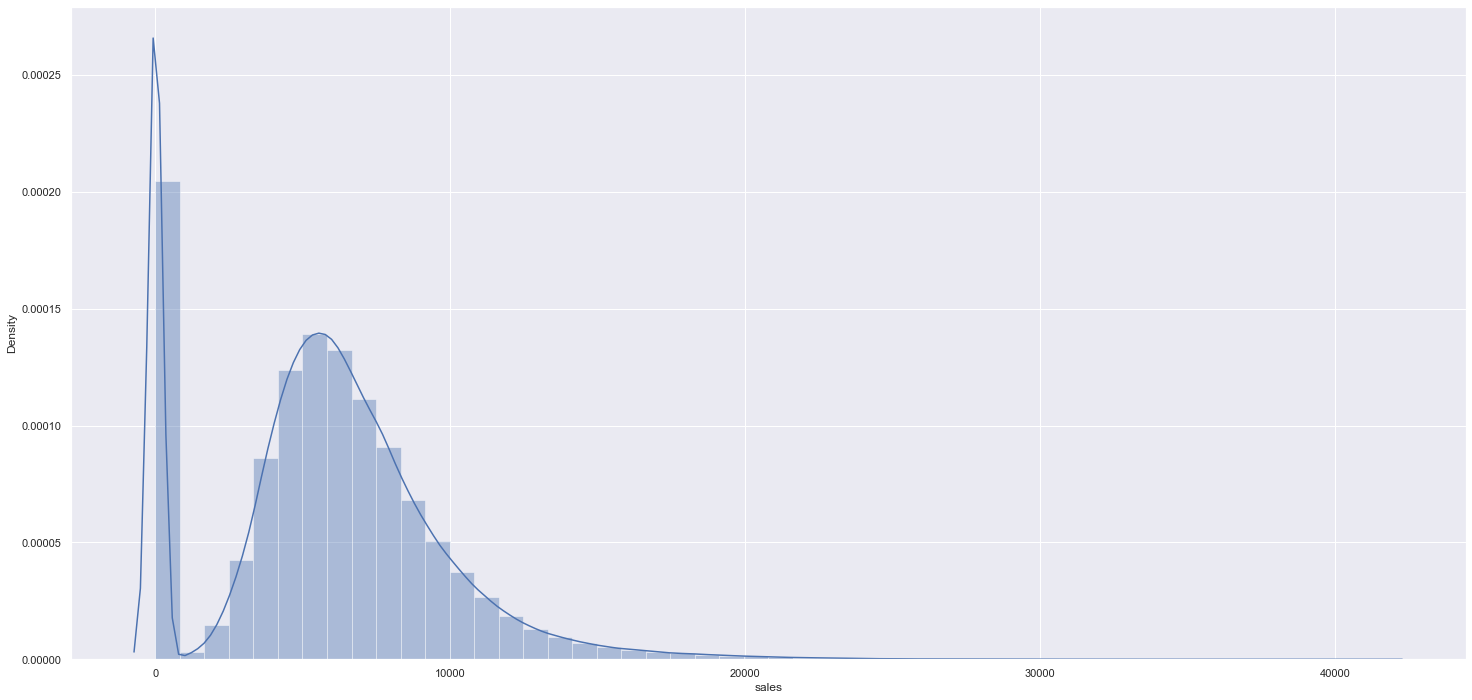

In [18]:
sns.distplot(df01['sales'])

### 1.7.1. Categorical Attributes

In [19]:
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday     4
store_type        4
assortment        3
promo_interval    4
dtype: int64

<AxesSubplot:xlabel='assortment', ylabel='sales'>

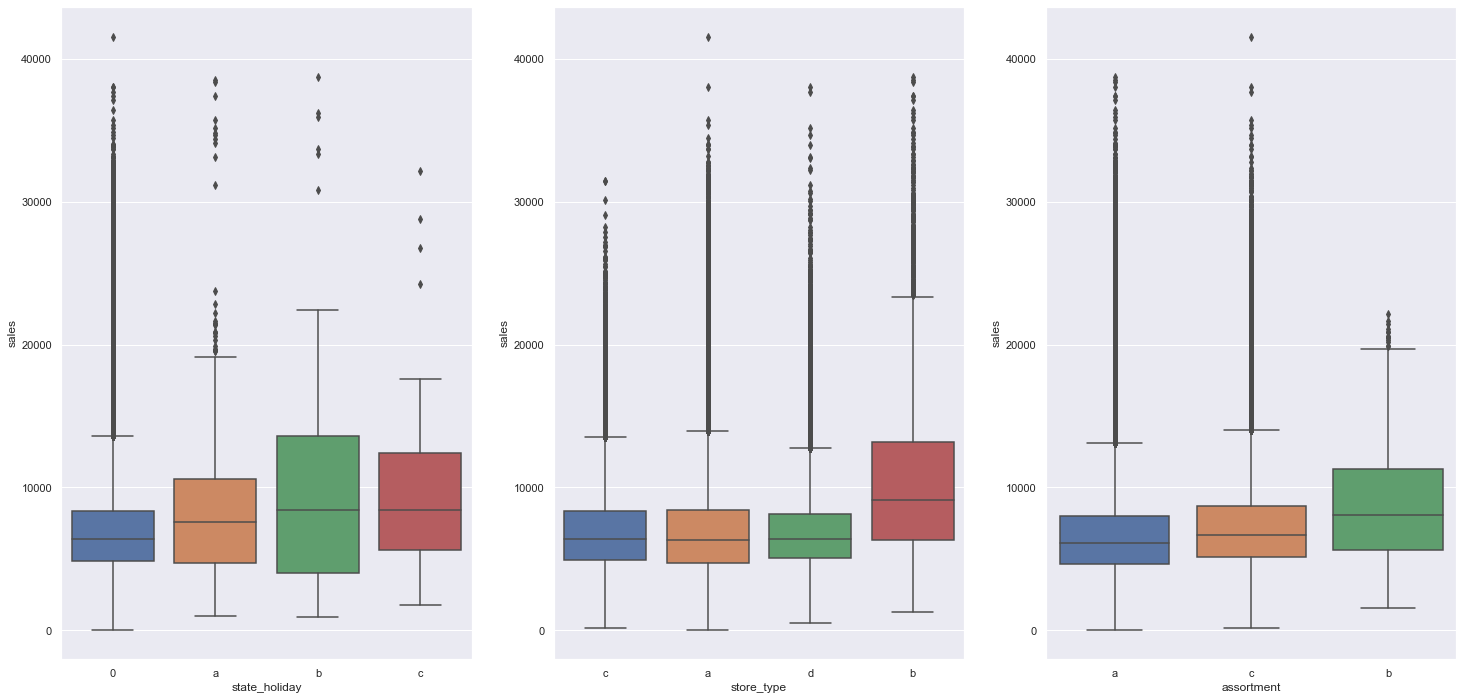

In [20]:
aux1 = df01.loc[(df01['state_holiday'] != 0) & (df01['sales'] >0)]

plt.subplot(1,3,1)
sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1,3,2)
sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.boxplot(x='assortment', y='sales', data=aux1)

# 2.0. FEATURE ENGINEERING

In [21]:
df02 = df01.copy()

## 2.1. Mapa Mental de Hipoteses

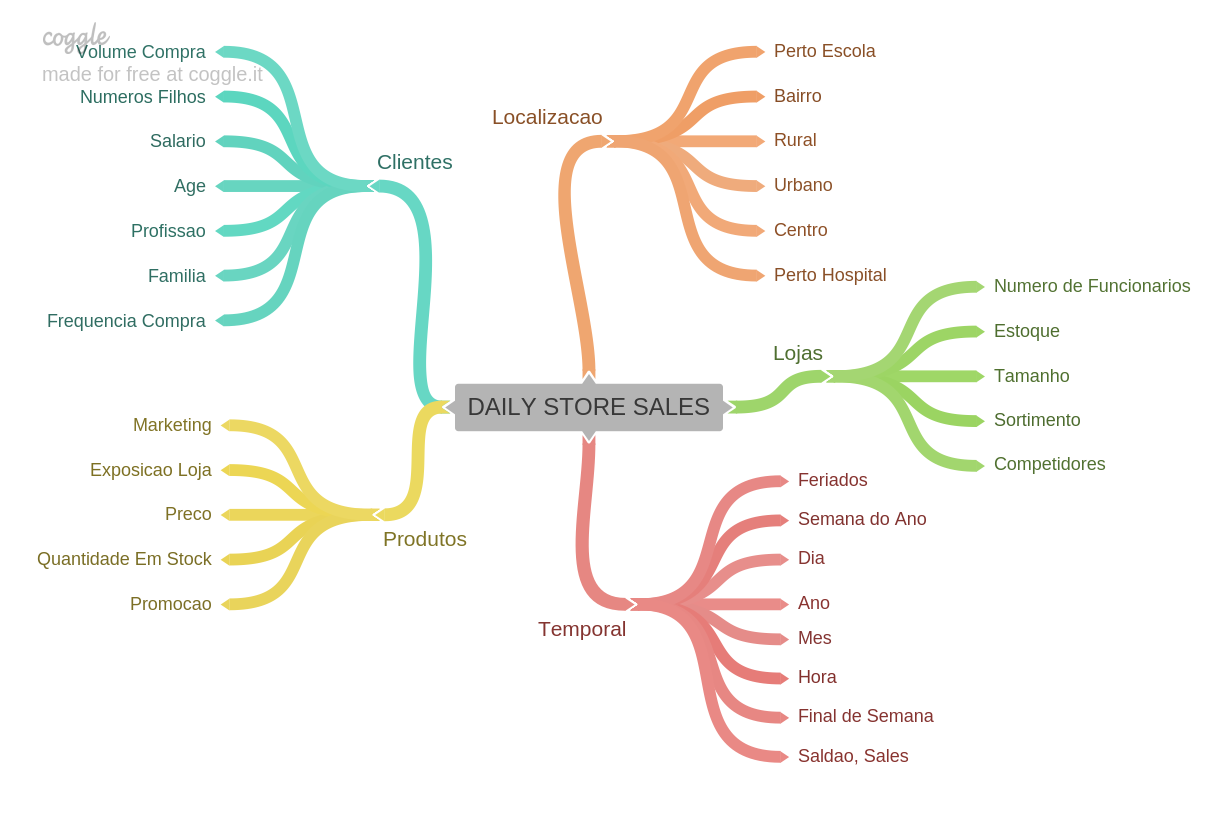

In [22]:
Image('../img/MindMapHypothesis.png')

## 2.2. Criacao das Hipoteses

### 2.1.1. Hipoteses Loja

<b>1. Lojas com maior quadro de funcionários deveriam vender mais
    
<b>2. Lojas com maior estoque deveriam vender mais
    
<b>3. Lojas com maior porte deveriam vender mais
    
<b>4. Lojas com maior sortimento deveriam vender mais

<b>5. Lojas com competidores mais proximos deveriam vender menos
    
<b>6. Lojas que têm competidores mais tempo deveriam vender mais (estabilização)

### 2.1.2. Hipoteses Produto

<b>1. Lojas quem investem mais em Marketing deveriam vender mais
    
<b>2. Lojas que expõe mais os produtos nas vitrines deveriam vender mais
    
<b>3. Lojas quem tem precos menores dos produtos deveriam vender mais
   
<b>4. Lojas com promoções mais agressivas deveriam vender mais
    
<b>5. Lojas com promoções ativas por mais tempo deveriam vender mais
    
<b>6. Lojas com mais dias de promoção deveriam vender mais
    
<b>7. Lojas com mais promoções consecutivas deveriam vender mais

### 2.1.3. Hipoteses Tempo

<b>1. Lojas abertas durante o feriado de Natal deveriam vender mais
    
<b>2. Lojas deveriam vender mais ao longo dos anos

<b>3. Lojas deveriam vender mais no segundo semestre do ano
    
<b>4. Lojas deveriam vender mais depois do dia 10 de cada mês
    
<b>5. Lojas deveriam vender menos aos finais de semana
    
<b>6. Lojas deveriam vender menos durante os feriados escolares

## 2.3. Lista final de hipoteses
--> Selecionando as hipoteses que posso validar com os dados nesse momento

<b>1. Lojas com maior sortimento deveriam vender mais

<b>2. Lojas com competidores mais proximos deveriam vender menos
    
<b>3. Lojas que têm competidores mais tempo deveriam vender mais (estabilização)

<b>4. Lojas com promoções ativas por mais tempo deveriam vender mais
    
<b>5. Lojas com mais dias de promoção deveriam vender mais
    
<b>6. Lojas com mais promoções consecutivas deveriam vender mais

<b>7. Lojas abertas durante o feriado de Natal deveriam vender mais
    
<b>8. Lojas deveriam vender mais ao longo dos anos

<b>9. Lojas deveriam vender mais no segundo semestre do ano
    
<b>10. Lojas deveriam vender mais depois do dia 10 de cada mês
    
<b>11. Lojas deveriam vender menos aos finais de semana
    
<b>12. Lojas deveriam vender menos durante os feriados escolares

## 2.4. Feature Engineering

In [23]:
df02['date']

0         2015-07-31
1         2015-07-30
2         2015-07-29
3         2015-07-28
4         2015-07-27
             ...    
1017204   2013-01-05
1017205   2013-01-04
1017206   2013-01-03
1017207   2013-01-02
1017208   2013-01-01
Name: date, Length: 1017209, dtype: datetime64[ns]

In [24]:
# year
df02['year'] = df02['date'].dt.year

# month
df02['month'] = df02['date'].dt.day

# day
df02['day'] = df02['date'].dt.day

# week of year
df02['week_of_year'] = df02['date'].dt.strftime('%W')

# year week
df02['year_week'] = df02['date'].dt.strftime('%Y-%W')

# competition since
df02['competition_since'] = pd.to_datetime(df02['competition_open_since_year'].astype(str) + 
               '-' + df02['competition_open_since_month'].astype(str), format='%Y-%m')

df02['competition_time_month'] = (( df02['date'] - df02['competition_since'])/30).dt.days


# promo since -- > needs a day of week to transform to date
df02['promo_since'] = pd.to_datetime(
    df02['promo2_since_year'].astype(str) + '-' 
    + df02['promo2_since_week'].astype(str) + '-0',  format='%Y-%W-%w')

df02['promo_time_week'] = ((df02['date'] - df02['promo_since'])/7).dt.days# how many weeks in promo

# assorment
dic_assorment = {'a': 'basic', 'b': 'extra', 'c': 'extended'}
df02['assortment'] = df02['assortment'].replace(dic_assorment)

# state holiday
dic_holidays = {'a': 'public_holiday', 'b': 'easter_holiday', 'c': 'christmas', '0':'regular_day'}
df02['state_holiday'] = df02['state_holiday'].replace(dic_holidays)

# 3.0. FILTRAGEM DE VARIAVEIS

In [25]:
df03 = df02.copy()

In [26]:
df03.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,...,0,2015,31,31,30,2015-30,2008-09-01,84,2015-08-09,-2
1,1,4,2015-07-30,5020,546,1,1,regular_day,1,c,...,0,2015,30,30,30,2015-30,2008-09-01,84,2015-08-09,-2
2,1,3,2015-07-29,4782,523,1,1,regular_day,1,c,...,0,2015,29,29,30,2015-30,2008-09-01,84,2015-08-09,-2
3,1,2,2015-07-28,5011,560,1,1,regular_day,1,c,...,0,2015,28,28,30,2015-30,2008-09-01,84,2015-08-09,-2
4,1,1,2015-07-27,6102,612,1,1,regular_day,1,c,...,0,2015,27,27,30,2015-30,2008-09-01,84,2015-08-09,-2


## 3.1. Filtragem das Linhas

In [27]:
df03 = df03[(df03['open'] != 0) & (df03['sales'] > 0)]

In [28]:
df03.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

## 3.2. Filtragem das Colunas

In [29]:
cols_drop = ['customers', 'open']
df03 = df03.drop(columns=cols_drop)

# 4.0. ANALISE EXPLORATORIA DOS DADOS

In [30]:
df04=df03.copy()

## 4.1. Analise Univariada

### 4.1.1. Response Variable

C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


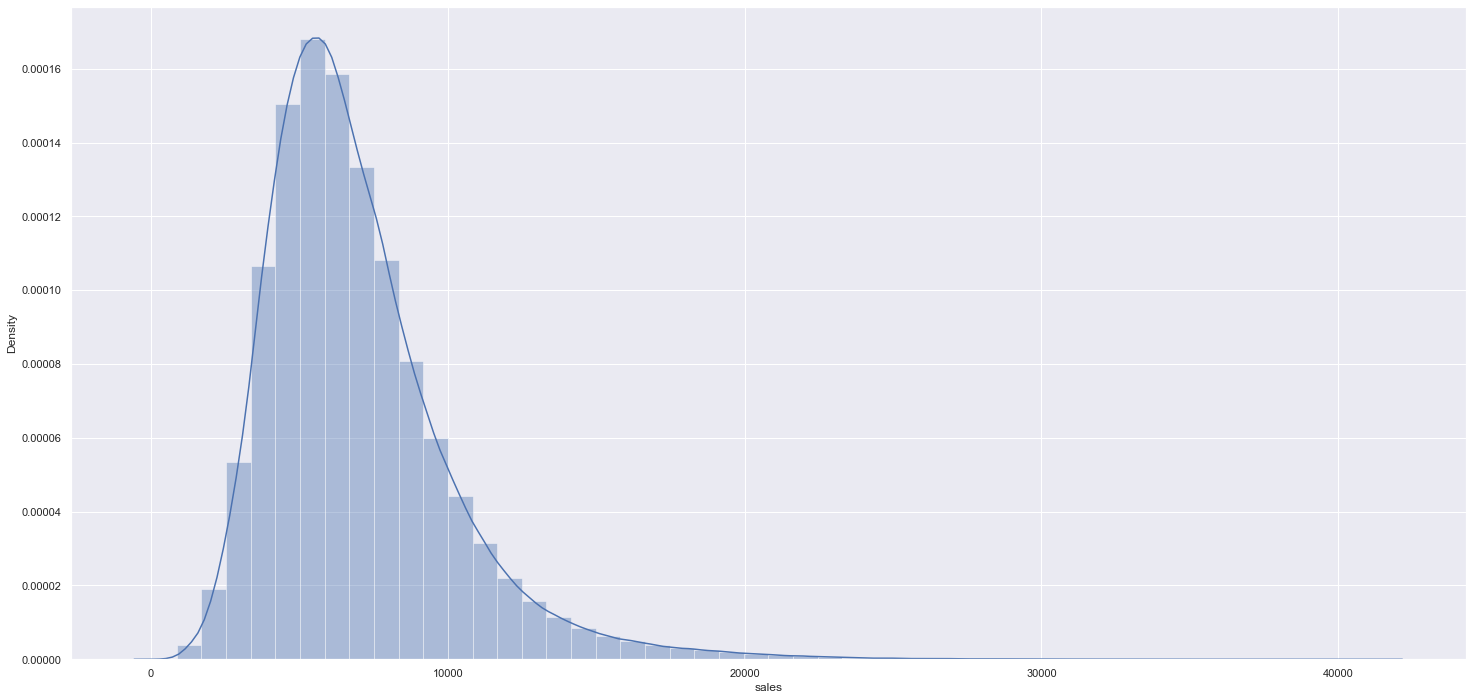

In [31]:
sns.distplot(df03['sales'])
plt.show()

### 4.1.2. Numerical Variable

array([[<AxesSubplot:title={'center':'store'}>,
        <AxesSubplot:title={'center':'day_of_week'}>,
        <AxesSubplot:title={'center':'sales'}>,
        <AxesSubplot:title={'center':'customers'}>],
       [<AxesSubplot:title={'center':'open'}>,
        <AxesSubplot:title={'center':'promo'}>,
        <AxesSubplot:title={'center':'school_holiday'}>,
        <AxesSubplot:title={'center':'competition_distance'}>],
       [<AxesSubplot:title={'center':'competition_open_since_month'}>,
        <AxesSubplot:title={'center':'competition_open_since_year'}>,
        <AxesSubplot:title={'center':'promo2'}>,
        <AxesSubplot:title={'center':'promo2_since_week'}>],
       [<AxesSubplot:title={'center':'promo2_since_year'}>,
        <AxesSubplot:title={'center':'is_promo'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

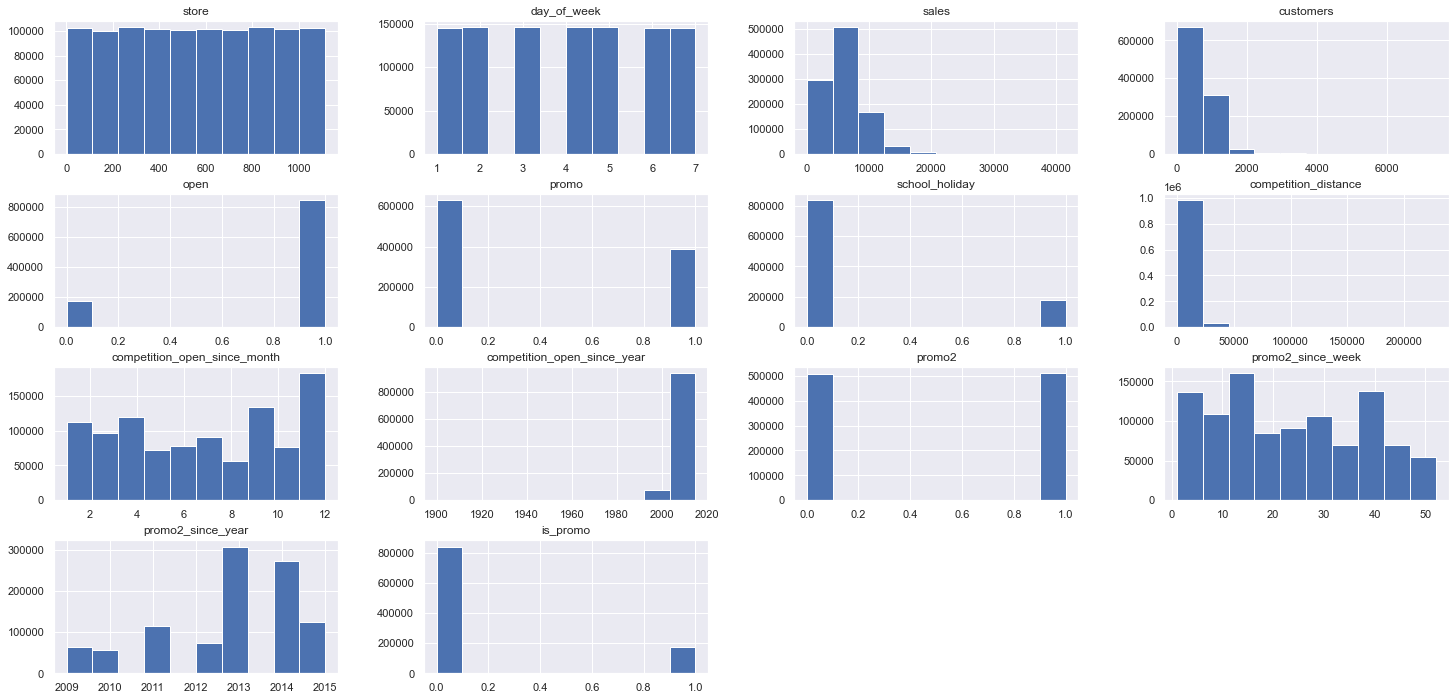

In [32]:
num_attributes.hist()

### 4.1.3. Categorical Variable

In [33]:
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval
0,0,c,a,0
1,0,c,a,0
2,0,c,a,0
3,0,c,a,0
4,0,c,a,0


C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
C:\Users\Miguel\anaconda3\envs\dsemproducao_venv\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an erro

<AxesSubplot:xlabel='sales', ylabel='Density'>

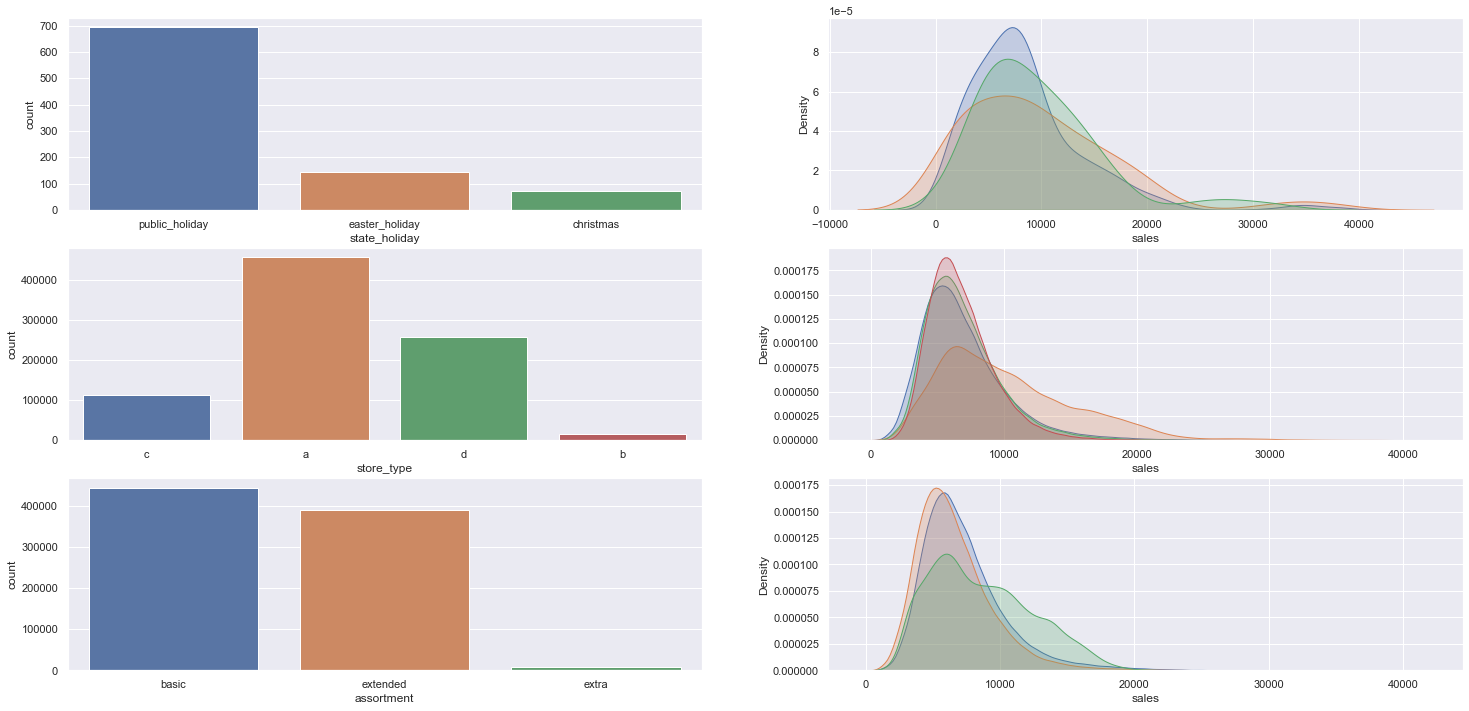

In [34]:
# state_holiday
plt.subplot(3,2,1)
a = df04[df04['state_holiday'] != 'regular_day'] # just because regular day is massive big
sns.countplot(a['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df04[df04['state_holiday'] == 'public_holiday']['sales'],label= 'public_holiday',shade=True) # shade=more transparent
sns.kdeplot(df04[df04['state_holiday'] == 'easter_holiday']['sales'],label= 'easter_holiday',shade=True)
sns.kdeplot(df04[df04['state_holiday'] == 'christmas']['sales'],label= 'christmas',shade=True)
#sns.kdeplot(df04[df04['state_holiday'] == 'regular_day']['sales'],label= 'regular_day',shade=True)

# store_type
plt.subplot(3,2,3)
sns.countplot(df04['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df04[df04['store_type'] == 'a']['sales'],label= 'a',shade=True) # shade=more transparent
sns.kdeplot(df04[df04['store_type'] == 'b']['sales'],label= 'b',shade=True)
sns.kdeplot(df04[df04['store_type'] == 'c']['sales'],label= 'c',shade=True)
sns.kdeplot(df04[df04['store_type'] == 'd']['sales'],label= 'd',shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df04['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df04[df04['assortment'] == 'extended']['sales'],label= 'extended',shade=True) # shade=more transparent
sns.kdeplot(df04[df04['assortment'] == 'basic']['sales'],label= 'basic',shade=True)
sns.kdeplot(df04[df04['assortment'] == 'extra']['sales'],label= 'extra',shade=True)

## 4.2. Analise Bivariada

<b>4. Lojas com promoções ativas por mais tempo deveriam vender mais
    
<b>5. Lojas com mais dias de promoção deveriam vender mais
    
<b>6. Lojas com mais promoções consecutivas deveriam vender mais

<b>7. Lojas abertas durante o feriado de Natal deveriam vender mais
    
<b>8. Lojas deveriam vender mais ao longo dos anos

<b>9. Lojas deveriam vender mais no segundo semestre do ano
    
<b>10. Lojas deveriam vender mais depois do dia 10 de cada mês
    
<b>11. Lojas deveriam vender menos aos finais de semana
    
<b>12. Lojas deveriam vender menos durante os feriados escolares

### H1. Lojas com maior sortimento deveriam vender mais
    
<b><font color='green'>VERDADEIRO</font>, apesar de basic ter um maior somatorio de vendas (e lojas), o extended possui maior média.

Obs: Tamanho de sortimento --- basic < extended < extra)

Number of stores/Assortment
basic       593
extended    513
extra         9
Name: Assortment, dtype: int64


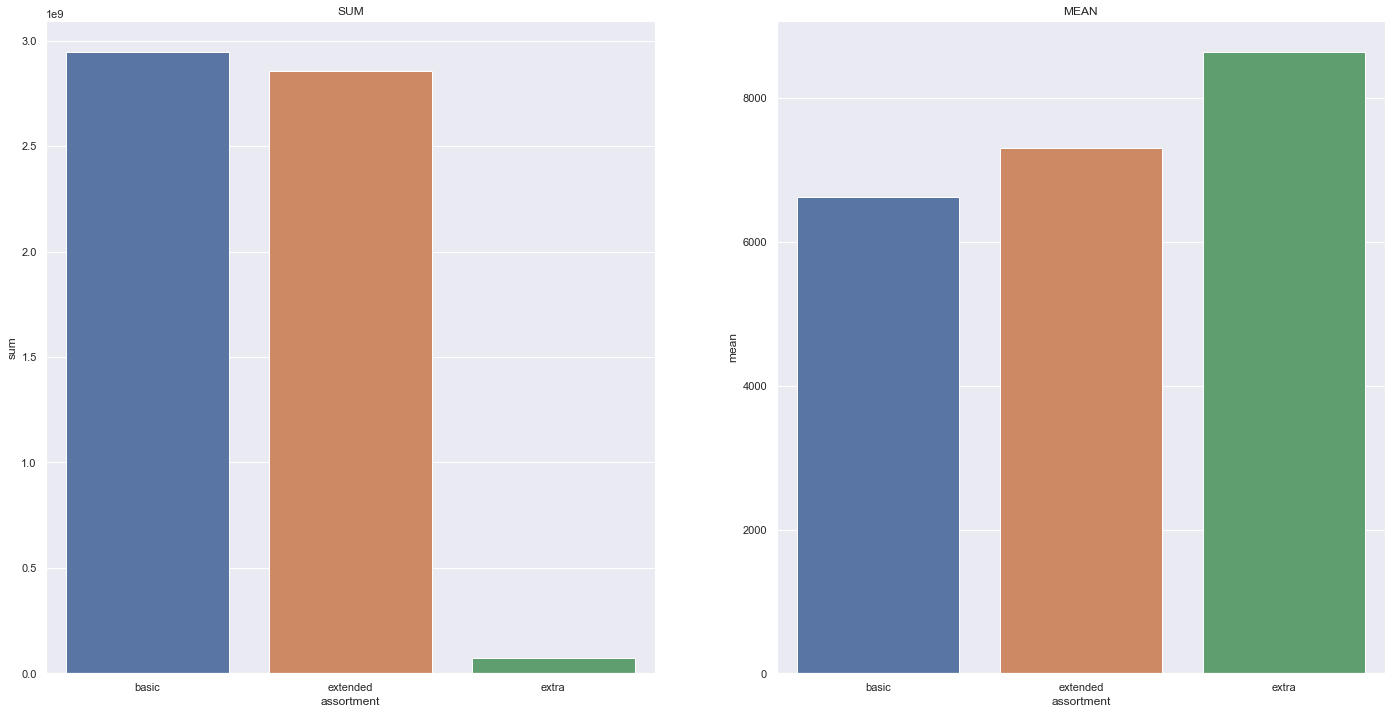

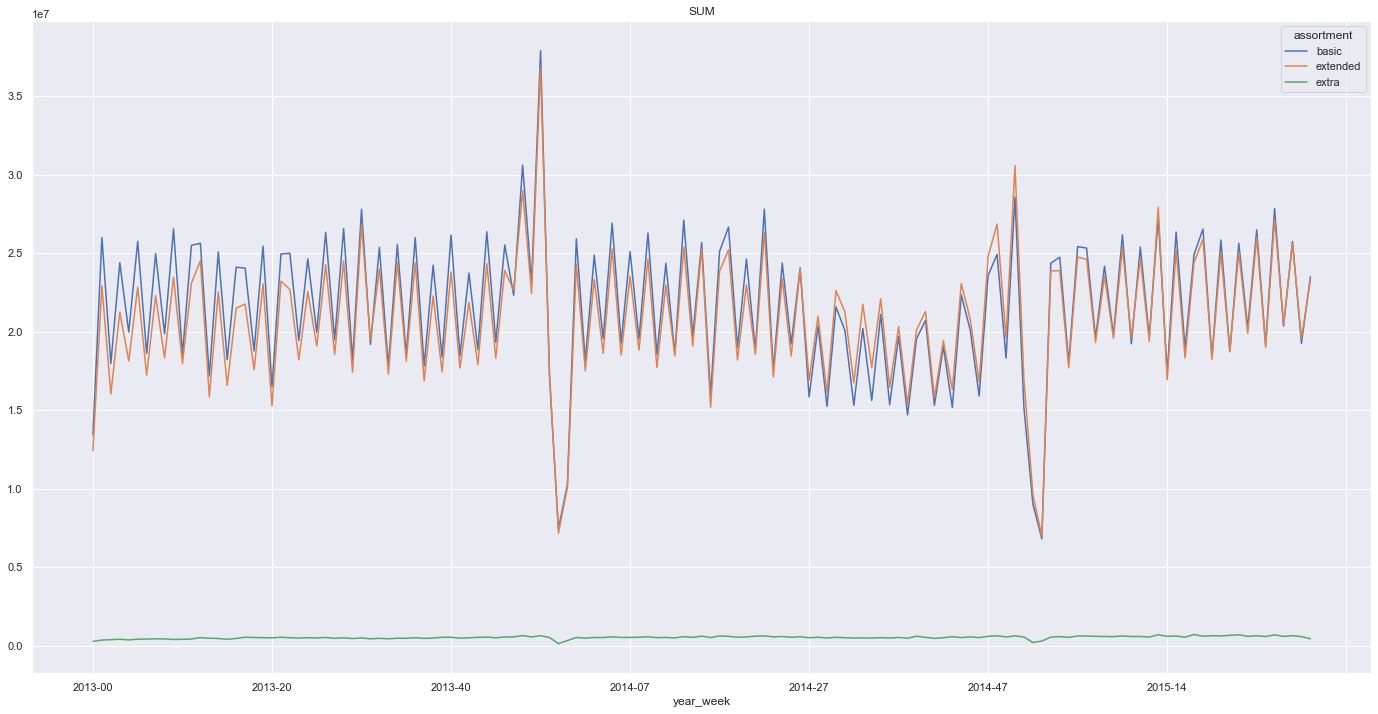

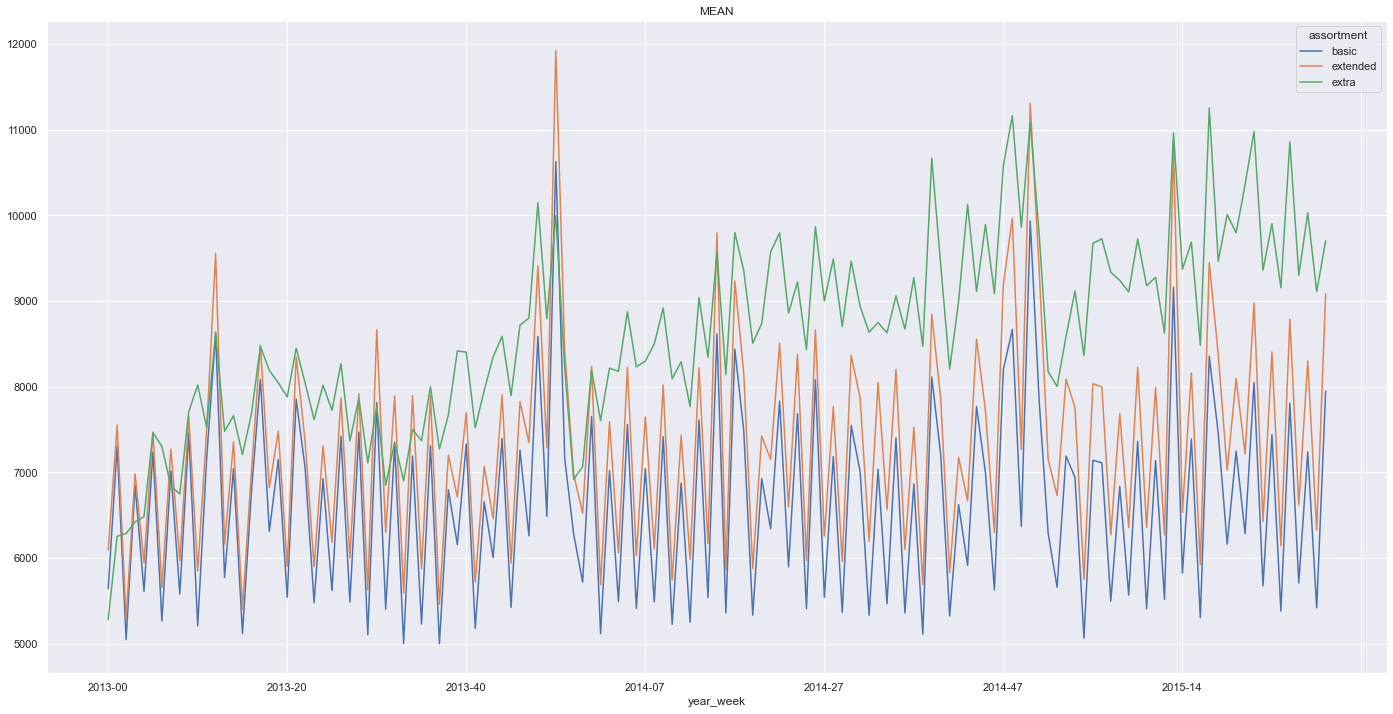

In [174]:
print('Number of stores/Assortment')
print(df_store_raw['Assortment'].value_counts().rename({'a':'basic', 'b': 'extra', 'c': 'extended'}));

h1_group = df04[['assortment', 'sales']].groupby('assortment')
h1_df = pd.DataFrame({
    'count': h1_group.count()['sales'],
    'mean': h1_group.mean()['sales'],
    'sum': h1_group.sum()['sales']
})

plt.subplot(1,2,1)
sns.barplot(x=h1_df.index, y='sum', data=h1_df).set_title('SUM')
plt.subplot(1,2,2)
sns.barplot(x=h1_df.index, y='mean', data=h1_df).set_title('MEAN')

plt.show()

h1_group_week = df04[['year_week', 'assortment', 'sales']].groupby(['year_week', 'assortment'])
aux1 = h1_group_week.sum().reset_index().pivot(index='year_week', columns='assortment', values='sales')
aux2 = h1_group_week.mean().reset_index().pivot(index='year_week', columns='assortment', values='sales')
aux1.plot(title='SUM')
aux2.plot(title='MEAN')
plt.show()

### H2. Lojas com competidores mais proximos deveriam vender menos
    
<b><font color='red'>FALSO</font>, o somatorio de vendas em lojas com competidores é maior e aparentemente a média de vendas não sofre mudanças substanciais com a distância.


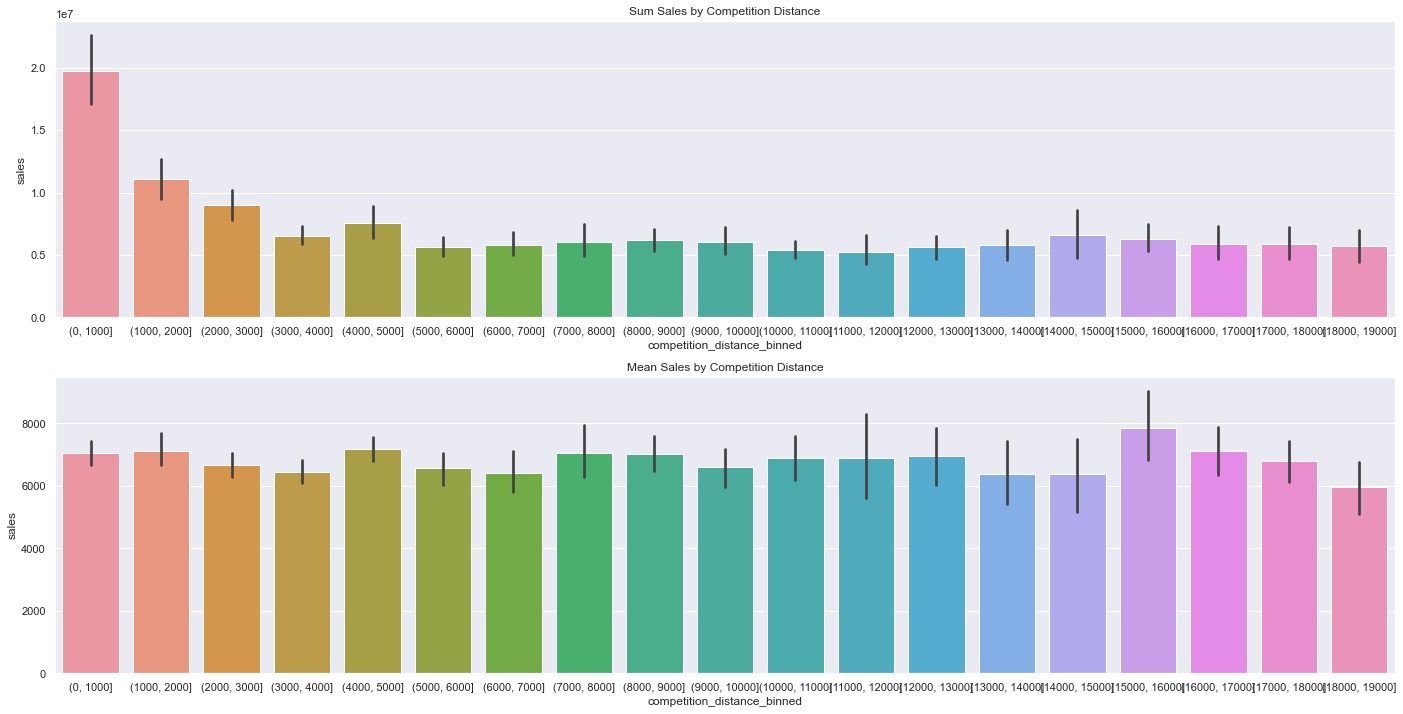

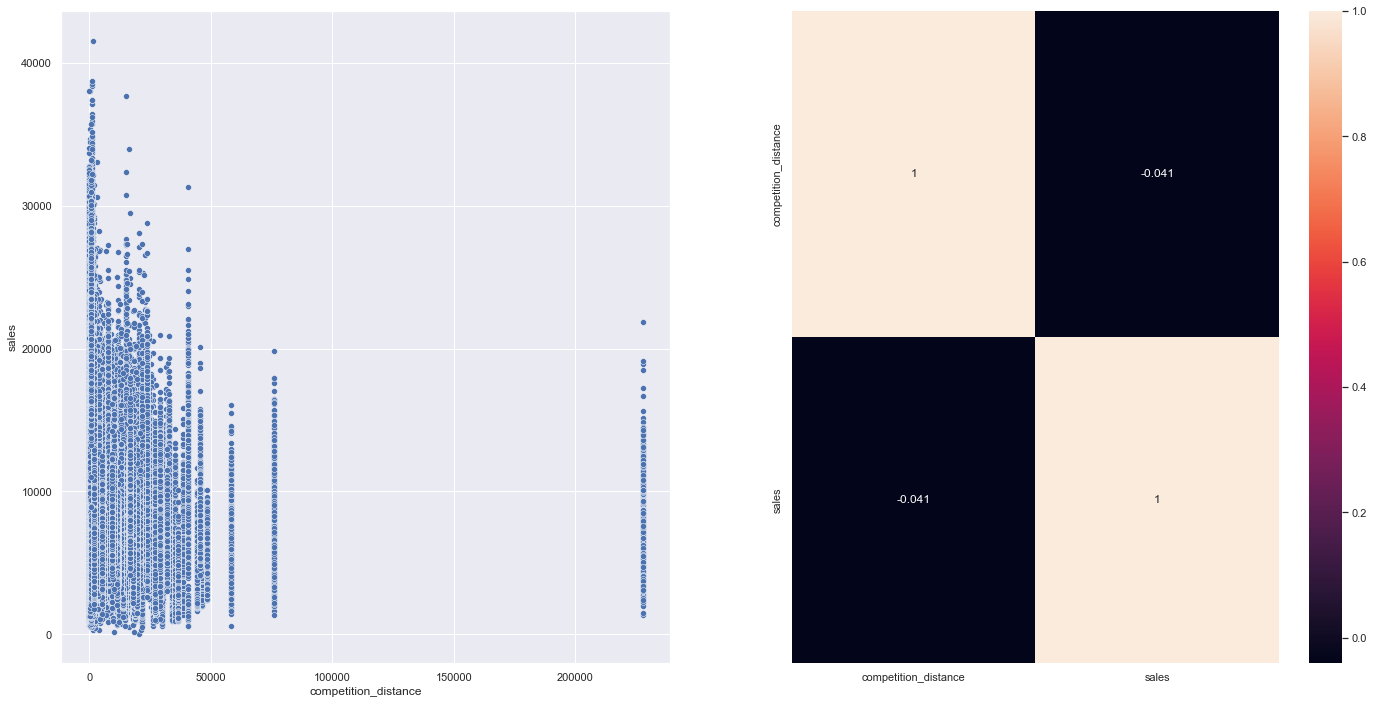

In [141]:
bins = list(np.arange(0,20000,1000))
# SUM
aux1 = df04[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

aux1['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)
plt.subplot(2,1,1)
sns.barplot(x='competition_distance_binned', y='sales', data=aux1).set_title('Sum Sales by Competition Distance')


# MEAN
aux2 = df04[['competition_distance', 'sales']].groupby('competition_distance').mean().reset_index()

aux2['competition_distance_binned'] = pd.cut( aux1['competition_distance'], bins=bins)

plt.subplot(2,1,2)
sns.barplot(x='competition_distance_binned', y='sales', data=aux2).set_title('Mean Sales by Competition Distance')
plt.show()

plt.subplot(1,2,1)
sns.scatterplot(x='competition_distance', y='sales', data=df04)

plt.subplot(1,2,2)
sns.heatmap(df04[['competition_distance', 'sales']].corr(method='pearson'), annot=True)
plt.show()

### H3. Lojas que têm competidores mais tempo deveriam vender mais (estabilização)
    
<b><font color='red'>FALSO</font>, o somatorio de vendas em lojas com competidores é maior e aparentemente a média de vendas não sofre mudanças substanciais com a distância.


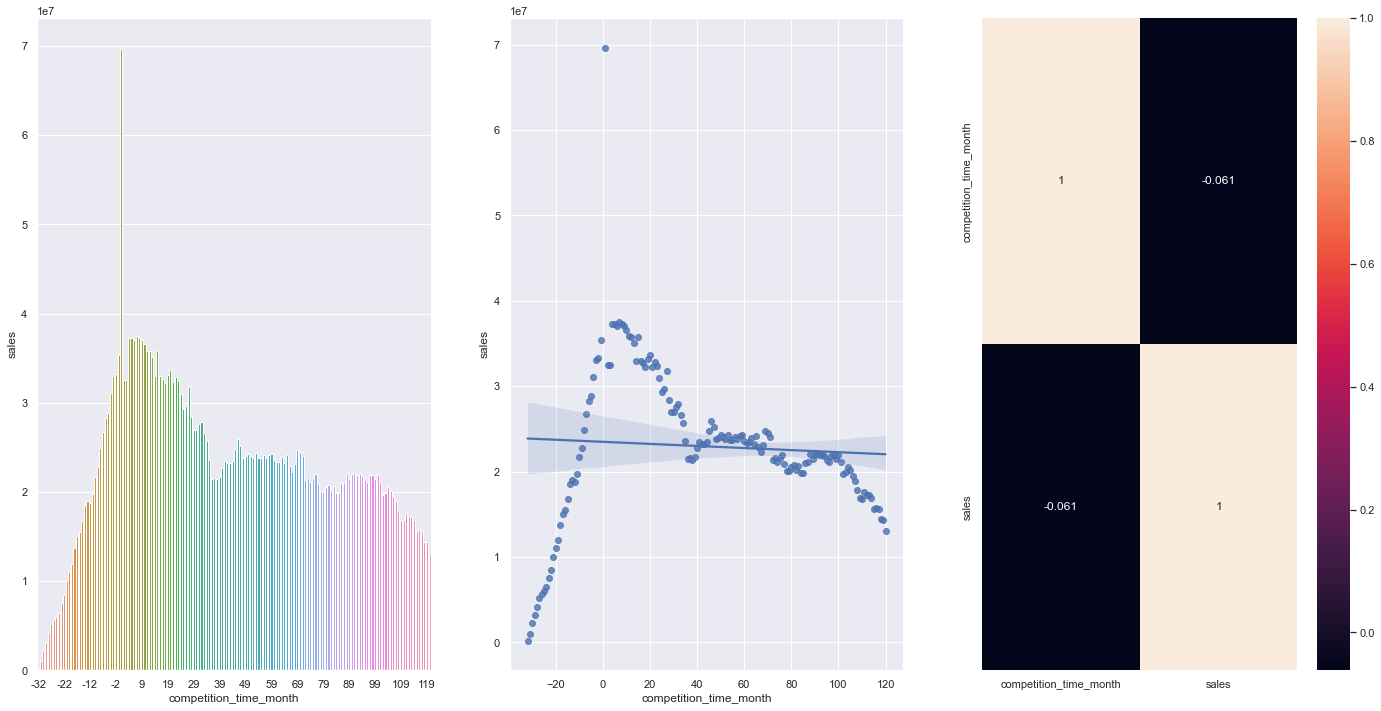

In [198]:
plt.subplot(1,3,1)
aux1 = df04[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()
aux1 = aux1[(aux1['competition_time_month'] <= 120) &  (aux1['competition_time_month'] != 0)]
ax = sns.barplot(x='competition_time_month', y='sales', data=aux1)
ax.xaxis.set_major_locator(ticker.MultipleLocator(10))

plt.subplot(1,3,2)
sns.regplot(x='competition_time_month', y='sales', data=aux1)

plt.subplot(1,3,3)
sns.heatmap(aux1.corr(method='pearson'), annot=True)
plt.show()

## 4.3. Analise Multivariada